In [ ]:
%%HTML
<!-- Mejorar visualización en proyector -->
<style>
.rendered_html {font-size: 1.2em; line-height: 150%;}
div.prompt {min-width: 0ex; padding: 0px;}
.container {width:95% !important;}
</style>

In [ ]:
%autosave 0
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import torch
from tqdm.notebook import tqdm
import corner

# A (brief) tutorial on [Pyro](https://pyro.ai/)

Pyro can be used to perform MCMC and/or approximate inference for intractable posteriors

We can use Pyro to move from point estimates to posteriors in our **torch-based model**

In [ ]:
import pyro
display(pyro.__version__)
pyro.set_rng_seed(101)

Let's start by creating a normal distribution

Distributions in Pyro are implemented in [`pyro.distributions`](http://docs.pyro.ai/en/stable/distributions.html)

The `Normal` object expects location $\mu$ and scale $\sigma$

In [ ]:
from pyro.distributions import Normal

w_prior = Normal(loc=torch.tensor(0.), 
                 scale=torch.tensor(1.))

We can sample from this distribution

In [ ]:
# Get 1000 samples 
samples = w_prior.rsample(sample_shape=(1000, ))
display(samples.shape)
# Build an histogram
fig, ax = plt.subplots(figsize=(7, 3))
plt.hist(samples.detach().numpy(), bins=20, density=True)
# Plot the pdf
w_plot = np.linspace(-3, 3, num=100)
w_pdf = torch.exp(w_prior.log_prob(torch.from_numpy(w_plot))).detach().numpy()
plt.plot(w_plot, w_pdf, 'k-', lw=2);

We can compute descriptors

In [ ]:
#mean
display(w_prior.mean)
#standard deviation
display(w_prior.stddev)
#entropy
display(w_prior.entropy())

#### Shape of pyro tensors

A distribution has two shapes

`event_shape` refers to the dimensionality of the distribution, e.g. normal (number), multivariate normal (vector), Cholesky (matrix), etc

> `event_shape` denotes dependent random variables

`batch_shape` refers to a batch of distributions

> `batch_shape` denotes conditionally independent random variables (typically our data dimension)

We can create a batched distribution by batching the parameters

The shape of a sampled tensor will be the sum of event and batch shapes

In [ ]:
# Two conditionally independent normal RVs
w_prior = Normal(torch.tensor([[0., 2.]]), torch.tensor([[1., 1.]]))
# A multivariate normal with diagonal covariance
#w_prior = Normal(torch.tensor([[0., 2.]]), torch.tensor([[1., 1.]])).to_event(1)

display(w_prior.batch_shape)
display(w_prior.event_shape)
display(w_prior.rsample().shape)

## Random variables in Pyro

To create random variables that we can track within a model we use [`pyro.sample`](http://pyro.ai/examples/intro_part_i.html#The-pyro.sample-Primitive)

`sample` expects a name and an object from [`pyro.distributions`](http://docs.pyro.ai/en/stable/distributions.html)

For example, to create a variable named "w" with the previously defined distribution
$$
\begin{align}
w \sim &\mathcal{N}(\mu, \sigma^2) \nonumber \\
&\mu = \begin{pmatrix}0 \\ 2 \end{pmatrix}, \sigma = \begin{pmatrix} 1 \\ 1 \end{pmatrix} \nonumber
\end{align}
$$

In [ ]:
def model():
    return pyro.sample(name='w', fn=w_prior)

Each time we run a model a random sample is returned

In [ ]:
for i in range(10):
    print(model())

### Models and conditioning 

Let's consider a linear regression model

$$
y_i = w x_i + b, \forall i
$$

We will write this model in Pyro 

For this we consider
- $w$ and $b$ to be random variables with normal distributions (priors)
- $y$ to be a random variable with normal distribution (likelihood)
- $x$ to be a deterministic variable
- $y$ is continioned to the observed data $\{y_i\}$


In [ ]:
def model(x):
    w = pyro.sample("w", Normal(0.0, 10.0))
    b = pyro.sample("b", Normal(0.0, 10.0))
    with pyro.plate('dataset', size=len(x)):
        return pyro.sample("y", Normal(x*w + b, 1.0))

def conditioned_model(x, y):
    return pyro.condition(model, data={"y": y})(x)

# or equivalently

def model_obs(x, y=None):  # equivalent to conditioned_scale above
    w = pyro.sample("w", Normal(0.0, 10.0))
    b = pyro.sample("b", Normal(0.0, 10.0))
    with pyro.plate('dataset', size=len(x)):
        return pyro.sample("y", Normal(x*w + b, 1.0), obs=y)

#### Technical details

To create conditions we can use `pyro.condition` or the `obs` keyword of `pyro.sample`

To create conditions on the whole dataset (assuming iid) we use [`pyro.plate`](http://docs.pyro.ai/en/stable/primitives.html#pyro.plate), which expects a name and the size of the dataset

In this case we use `pyro.plate` as a context (vectorized plate), it can also be used as an iterator


#### Theorical details

In summary the model has to define the generative process 

In this case
- Choose hyperparameters: $\mu_w, \sigma_w, \mu_b, \sigma_b, \sigma_\epsilon$
- Sample: $w \sim \mathcal{N}(\mu_w, \sigma_w^2)$
- Sample: $b \sim \mathcal{N}(\mu_b, \sigma_b^2)$
- For each $i=1,2,\ldots, N$
    - Sample: $y_i \sim \mathcal{N}(w x_i + b, \sigma_\epsilon^2)$

This is often summarized using plate notation diagrams

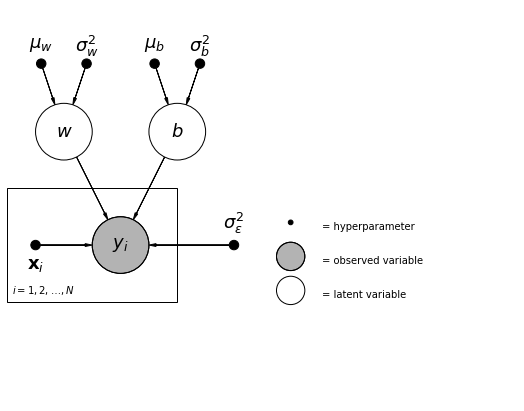

# Inference

Now that we have specified the model we would like to obtain the posterior of the parameters given the data and do predictions

> If we can not solve it analytically or via enumeration we can resort to approximate inference

Pyro offers different ways to perform approximate inference in the module [`pyro.infer`](https://docs.pyro.ai/en/stable/inference.html)

For now we will focus on **Stochastic Variational Inference** 


The unified Variational Inference interface in Pyro is located in [`pyro.infer.SVI`](http://docs.pyro.ai/en/stable/inference_algos.html) 

To use SVI we need to specify
1. A model function that defines our generative model
1. A guide function that defines our approximate posterior
1. A cost function 
1. An optimizer
1. Number of samples to compute Monte-Carlo estimates

### Guide function

> The guide represents our approximate posterior $q_\nu(\theta)$ 

The guide has to define the distribution of the posterior of the parameters 

We use [`pyro.param`]() to register the hyperparameters of the approximate posterior $\eta$

> These parameters are the ones that we learn through optimization

**Technical detail:** The guide function has the same inputs as the model function

In this example we set a normal posterior $\theta=(w, b)$ and create the corresponding hyperparameters $\eta = (\mu_w, \sigma_w, \mu_b, \sigma_b)$

In [ ]:
from torch.distributions import constraints

def guide(x, y=None):
    w_loc = pyro.param("w_loc", torch.tensor(0.))
    w_scale = pyro.param("w_scale", torch.tensor(1.), constraint=constraints.positive)
    w = pyro.sample("w", Normal(w_loc, w_scale))
    b_loc = pyro.param("b_loc", torch.tensor(0.))
    b_scale = pyro.param("b_scale", torch.tensor(1.), constraint=constraints.positive)
    b = pyro.sample("b", Normal(b_loc, b_scale))

### Cost function

In the previous class we studied the Evidence Lower Bound (ELBO)

$$
\begin{align}
\hat \nu &= \text{arg}\max_\nu \mathcal{L}(\nu) \nonumber \\
&= \text{arg}\max_\nu - \int q_\nu(\theta) \log \frac{q_\nu(\theta)}{p(\mathcal{D}|\theta) p (\theta)} d\theta
\end{align}
$$

where
- The model function defines $p(\mathcal{D}|\theta) p (\theta)$ 
- The guide function defines $q_\nu(\theta)$ 

Pyro offers several versions of the [ELBO](https://docs.pyro.ai/en/stable/inference_algos.html#module-pyro.infer.elbo)

- `Trace_ELBO`: Default ELBO. Reduces variance of the gradients using "Rao-Blackwellization"
- `TraceEnum_ELBO`: Performs exhaustive enumeration for discrete variables
- `TraceMeanField_ELBO`: Assumes Mean-field structure. Reduce variance of gradients using analytical KL when possible

> We will study the importance of gradient variance later

### Training

Once we have defined the model and guide we create an SVI object

In this example we select the default ELBO and SGD with adaptive learning rate optimizer

In [ ]:
pyro.enable_validation(True) #Additional debug of model/guides

pyro.clear_param_store()

svi = pyro.infer.SVI(model=model_obs,  
                     guide=guide,
                     loss=pyro.infer.Trace_ELBO(), # Loss function
                     optim=pyro.optim.ClippedAdam({"lr": 0.01})) # Optimizer

The main method of SVI is 

- `svi.step(*args)`: Performs a gradient step, similar to the `backward()` plus `step()` in pytorch

`step()` receives the inputs for guide and model as arguments

In [ ]:
fig, ax = plt.subplots(1, 5, figsize=(10, 2.5), dpi=80, tight_layout=True)
lines = [ax_.plot([], [])[0] for ax_ in ax]
param_names = ["ELBO", "w_loc", "w_scale", "b_loc", "b_scale"]
param_evolution = {}
for name in param_names:
    param_evolution[name] = []
    
for ax_, name in zip(ax, param_names):
    ax_.set_title(name)

In [ ]:
# Observed data
x = torch.tensor([-2., 2.])
y = torch.tensor([-2., 2.])
    
for k in tqdm(range(3000)):
    param_evolution["ELBO"].append(svi.step(x, y))
    for name in param_names[1:]:
        param_evolution[name].append(pyro.param(name).item()) 
    
    if np.mod(k, 100) == 0:
        for i, name in enumerate(param_names):
            lines[i].set_ydata(param_evolution[name][:k])
        for line in lines:
            line.set_xdata(range(k))
        for ax_ in ax.ravel():
            ax_.relim()
            ax_.autoscale_view()
        fig.canvas.draw()

We see that the ELBO and the parameters have converged


## Posterior predictive 

We can evaluate the quality of the trained model by visualizing the posterior of $w$ and $b$ and the posterior predictive of $y$ given $x$


For this we can use the utility class [`pyro.infer.Predictive`](http://docs.pyro.ai/en/stable/inference_algos.html#pyro.infer.predictive.Predictive)

In [ ]:
line_x = np.linspace(-5, 5, num=100).astype('float32') 

predictive = pyro.infer.Predictive(model_obs, 
                                   guide=guide, 
                                   num_samples=5000,
                                   return_sites=("w", "b", "y"))

samples = predictive(torch.from_numpy(line_x))

# Posterior of w and b
b_plot_vi = samples['b'].detach().numpy()[:, 0]
w_plot_vi = samples['w'].detach().numpy()[:, 0]
figure = corner.corner(np.stack((b_plot_vi, w_plot_vi)).T, 
                       smooth=1., labels=["bias", "weight"], bins=20, 
                       quantiles=[0.16, 0.5, 0.84], range=[(-2, 2), (-1, 3)],
                       show_titles=True, title_kwargs={"fontsize": 12})

In [ ]:
# Posterior predictive of y given x
y_trace = samples["y"].detach().numpy()
med = np.median(y_trace, axis=0)
qua = np.quantile(y_trace, (0.05, 0.95), axis=0)

fig, ax = plt.subplots(figsize=(7, 3), tight_layout=True)
ax.plot(line_x, med)
ax.fill_between(line_x, qua[0], qua[1], alpha=0.5);

ax.errorbar(2, 2, xerr=0, yerr=2, fmt='none', c='k', zorder=100);
ax.errorbar(-2, -2., xerr=0, yerr=2, fmt='none', c='k', zorder=100);

### MCMC with Pyro

[On the MCMC side Pyro](https://docs.pyro.ai/en/stable/mcmc.html) offers Hamiltonian Monte-Carlo and the more recent No-U turn sampler (NUTS)

For theoretical details see Barber Chapter 27 or [here](https://github.com/magister-informatica-uach/INFO337/tree/master/MCMC)

Here we run MCMC as a reference

In [ ]:
from pyro.infer import MCMC, NUTS

nuts_kernel = NUTS(model_obs, adapt_step_size=True)
sampler = MCMC(nuts_kernel, num_chains=1, num_samples=1000, warmup_steps=1000)
sampler.run(x, y)

Print a summary:

In [ ]:
sampler.summary()

Plot the posteriors

In [ ]:
samples = sampler.get_samples()
w_plot_mcmc = samples['w'].detach().numpy()
b_plot_mcmc = samples['b'].detach().numpy()

figure = corner.corner(np.stack((b_plot_mcmc , w_plot_mcmc )).T, smooth=1.,
                       labels=["b", "w"], bins=20, 
                       quantiles=[0.16, 0.5, 0.84], range=[(-2, 2), (-1, 3)],
                       show_titles=True, title_kwargs={"fontsize": 12})

Not too different from the VI solution

But remember, in this case we used to actual posterior (normal) in the guide

**Most of the time we won't be so lucky**

# Pyro summary

- We create (deterministic) parameters with `pyro.param`
- We create latent random variables using `pyro.sample`
- We create observed random variables using `pyro.sample` with the `obs` keyword

> The model represents our graphical model

> The guide represents our assumptions on the latent variables

# Bayesian Neural Networks

> Deep Neural Networks are non-linear function approximators which represent the state of the art in pattern recognition

But they do have limitations

- Very deep models require lots of data and can be hard to train
- Selecting an architecture requires a lot of experimentation
- [Not too robust](https://openai.com/blog/adversarial-example-research/)
- Poor at representing uncertainty

> We can leverage some of these by going Bayesian

- A Bayesian neural network (BNN) places a prior distribution on its parameters 
- Training the BNN $\equiv$ Learning the posterior distribution of the parameters given the data
- The **uncertainty on the data and the parameters** can be propagated to estimate the **uncertainty on our predictions**
    - Uncertainty on the data is called **aleatoric uncertainty** and it is related to irreducible noise
    - Uncertainty on the model (parameters and structure) is called **epistemic uncertainty**

> We know what we don't know

We can use this "new knowledge" to
- Decide when to use a more simple/complex model (complexity-control)
- Decide when to take a critical decisions
    - Autonomouse cars
    - Cancer diagnosis

## A bit of history

> Bayesian neural networks is an active area of research 

- 1980's: Bayes theorem applied to Neural Networks (John Hopfield and Naftali Tishby)
- 1990's: Monte-Carlo and VI for bayesian neural networks was studied extensively by [David Mackay](http://www.inference.org.uk/mackay/BayesNets.html) and [Radford Neal](https://www.cs.toronto.edu/~radford/res-neural.html) (Also Bishop, Barber, Hinton, Gharamani and many others). Neal shows that Gaussian process are bayesian neural networks with infinite neurons

> The models remain quite difficult to train for some time

- 2010's: Deep learning arrives 
- 2011: [Alex Graves' VI for neural networks](https://papers.nips.cc/paper/4329-practical-variational-inference-for-neural-networks)
- Explosion of practical deep bayesian networks 
    - [Charles Blundell's Bayes by backprop](https://arxiv.org/abs/1505.05424)
    - [Yarin Gal's many work](http://mlg.eng.cam.ac.uk/yarin/thesis/thesis.pdf)
    - Durk Kingma, Danilo Jimenez Rezende, Shakir Mohamed, José Miguel Hernandez-Lobato
- [Hot topic now a days](http://bayesiandeeplearning.org/)

History in video by [Zoubin Gharamani](http://mlg.eng.cam.ac.uk/zoubin/) at [NIPS 2016](https://www.youtube.com/watch?v=FD8l2vPU5FY) and [interesting panel discussion](https://www.youtube.com/watch?v=HumFmLu3CJ8) on the same conference


### More formally


Assuming
- $N$ *iid* samples $\mathcal{D} =\{(x^{(1)}, y^{(1)}), (x^{(2)}, y^{(2)}), \ldots, (x^{(N)}, y^{(N)}) \}$ 
- $x$ is a $D$ dimensional vector
- Fully-connected neural network with one hidden layer ($H$ neurons) for regression
- $\text{sgm}(\cdot)$ is a non-linear activation function

$$
\begin{align}
f_\theta(x) &=   b_i + \sum_{j=1}^H w_{ij} h_j  \nonumber \\
&=  b_i + \sum_{j=1}^H w_{ij} \text{sgm} \left( b_j + \sum_{d=1}^D w_{jd} x_d  \right) \nonumber
\end{align}
$$

The parameter vector $\theta$ contains all the weights and biases of the model

**Prior:** We propose a prior for $\theta$, typically

$$
\theta \sim \mathcal{N}(\theta | 0, \Sigma_\theta)
$$

**Likelihood:** We propose a likelihood depending on our task, typically Gaussian for regression and Bernoulli/Categorical for binary/multiclass classification 

**Posterior:** We use Bayes theorem to write the posterior

$$
p(\theta | \mathcal{D}) = \frac{p(\mathcal{D}|\theta) p(\theta)}{p(\mathcal{D})} = \frac{1}{{p(\mathcal{D})}} \prod_n \mathcal{N}(y^{(n)} | f(x^{(n)}), \sigma^2) \mathcal{N}(\theta | 0, \Sigma_\theta)
$$

Even though the likelihood and prior are normal **the posterior in this case is not normal** because of the nested nonlinearity (Can you show this?)

In general:

> We cannot obtain an analytical posterior for a bayesian neural network

We resort to sampling-based (MCMC) or deterministic (VI) approximate inference (previous class)

## My first Bayesian Neural Network using Pyro


We will use the same synthetic data from our previous class

In [ ]:
# Synthetic data
se = 0.1
np.random.seed(0)
x = np.linspace(0, 1, num=20) 
x_test = np.linspace(-0.05, 1.05, num=200)
f = lambda x : x*np.sin(10*x)

x = np.delete(x, slice(9, 14))
y = f(x) + se*np.random.randn(len(x))
fig, ax = plt.subplots(figsize=(7, 3), tight_layout=True)
ax.scatter(x, y);

x_torch = torch.from_numpy(x.astype('float32')).unsqueeze(1)
x_test = torch.from_numpy(x_test.astype('float32')).unsqueeze(1)
y_torch = torch.from_numpy(y.astype('float32')).unsqueeze(1)

#### Coding the bayesian neural net

Neural nets in pyro are classes that inherit from `PyroModule`

This is done using `PyroModule` and `PyroSample` from [`pyro.nn`](https://docs.pyro.ai/en/stable/nn.html)

- `PyroSample` is used to declare a neural net parameter as a random variable 
- `PyroModule` is used to declare torch modules which accept random parameters

In the following example we lift `torch.nn.Linear` using `PyroModule`, and add priors its parameters using `PyroSample`

In this regression problem we assume that the output is Gaussian distributed

The likelihood is declared with its corresponding plate in the `forward` function

Once the network is coded we can use `pyro.poutine.trace` with pyro validation activated to make sure that the shapes are correct

- Batch dimension is 15 (number of samples)
- Event dimension is equal to the number of neurons for each layer

Independent RV (likelihood) should be in the left while dependent (weights and biases) should be on the right

This is controlled using plates and the `to_event()` attribute

In [ ]:
from pyro.nn import PyroSample, PyroModule
from pyro.distributions import Uniform, Normal, MixtureOfDiagNormals

class BayesianMLPRegression(PyroModule):
    def __init__(self, n_hidden=10, prior_scale=1.):
        super().__init__()
        prior = Normal(0, prior_scale)
        # Hidden layer
        self.hidden = PyroModule[torch.nn.Linear](1, n_hidden)
        self.hidden.weight = PyroSample(prior.expand([n_hidden, 1]).to_event(2))
        self.hidden.bias = PyroSample(prior.expand([n_hidden]).to_event(1))
        # Output layer
        self.output = PyroModule[torch.nn.Linear](n_hidden, 1)
        self.output.weight = PyroSample(prior.expand([1, n_hidden]).to_event(2))
        self.output.bias = PyroSample(prior.expand([1]).to_event(1))
        # activation function
        self.activation = torch.nn.Tanh()
        
    def forward(self, x, y=None):
        z = self.activation(self.hidden(x))
        mean = self.output(z).squeeze(-1)
        sigma = pyro.sample("sigma", Uniform(0.0, 0.1))
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", Normal(mean, sigma), obs=y) #likelihood
        return mean

In [ ]:
pyro.enable_validation(True)

model = BayesianMLPRegression()

print(pyro.poutine.trace(model).get_trace(x_torch, y_torch).format_shapes())

#### Training the BNN: MCMC 

Even for a extremely simple NN and using the most advanced samplers MCMC can be inpractical

(Don't try to wait for this to converge)

In [ ]:
from pyro.infer import MCMC, NUTS

pyro.clear_param_store() 
model = BayesianMLPRegression(n_hidden=10, prior_scale=1.) # Declare the neural network

nuts_kernel = NUTS(model, adapt_step_size=True)
sampler = MCMC(nuts_kernel, num_chains=1, num_samples=10000, warmup_steps=1000)
sampler.run(x_torch, y_torch)

### Summary of VI

Propose an approximate (simple) posterior $q_\nu(\theta)$ and optimize so that it looks similar to the actual posterior

We do this by maximizing a lower bound on the evidence

$$
\mathcal{L}(\nu) = \mathbb{E}_{q_\nu(\theta)}[ \log p(\mathcal{D}|\theta)] - \text{KL}[q_\nu(\theta)|p(\theta)]
$$

An we use $q_\nu(\theta)$ as our replacement for $p(\theta|\mathcal{D})$ to calculate the **posterior predictive distribution**

$$
p(\mathbf{y}|\mathbf{x}, \mathcal{D}) = \int p(\mathbf{y}|\mathbf{x}, \theta) p(\theta| \mathcal{D}) \,d\theta
$$


#### Training the BNN: VI

Once the model is specified we need to write a guide (approximate posterior)

This can be done manually as before or using the automatic guides in `pyro.infer.autoguide`. Typically we would start we the simplest diagonal normal guide (assumes no correlation between the parameters of the BNN)

Then we create an SVI object and call the `step` attribute of this object iteratively

We can evaluate the posteriors of the parameters and the predictive posterior using `pyro.infer.Predictive`

In what follows the neural network is trained for 10000 epochs and every 100 epochs the predictive posterior is plotted

In [ ]:
    fig, ax = plt.subplots(1, 2, figsize=(10, 3), tight_layout=True, dpi=80)
    #ax[0].set_yscale('log')

    def update_plot(k, epoch_loss, samples):
        ax[0].cla()
        ax[0].plot(range(k), epoch_loss[:k])
        #ax[0].autoscale_view()
        ax[1].cla()
        ax[1].plot(x, y, 'k.');
        med = np.median(samples, axis=[0])
        qua = np.quantile(samples, (0.05, 0.95), axis=0)
        ax[1].plot(x_test.numpy()[:, 0], med)
        ax[1].fill_between(x_test.numpy()[:, 0], qua[0], qua[1], alpha=0.5)
        fig.canvas.draw()

In [ ]:
pyro.enable_validation(True) # Turn this on for additional debugging
pyro.clear_param_store() 
model = BayesianMLPRegression(n_hidden=10, prior_scale=1.) # Declare the neural network

# Create a guide
from pyro.infer.autoguide import AutoDiagonalNormal
guide = AutoDiagonalNormal(model, init_scale=1e-2)

# Create SVI object
svi = pyro.infer.SVI(model, 
                     guide, 
                     optim=pyro.optim.ClippedAdam({'lr':1e-2, 'clip_norm': 10.0}), # Optimizer
                     loss=pyro.infer.Trace_ELBO()) # Loss function 

epoch_loss = np.zeros(shape=(10000,))
for k in tqdm(range(len(epoch_loss))):
    loss = svi.step(x=x_torch, y=y_torch.squeeze(-1)) # Actual training step
    epoch_loss[k] = loss / len(x_torch)
        
    if k % 100 == 0:
        # Compute predictive posterior
        predictive = pyro.infer.Predictive(model, guide=guide, num_samples=100)
        samples = predictive(x_test, None)['obs'].detach().numpy()
        # Plot it
        update_plot(k, epoch_loss, samples)        

After training is complete we can use the guide as our replacement to the posterior

The trained pararemeters of the guide are stored in

In [ ]:
for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name))

As before we can use `pyro.infer.Predictive` to get samples from our bayesian neural network when evaluated on new inputs 

Here we sample "100 neural networks" and evaluate them on `x_test` 

This returns the sampled parameters (weights and biases) and outputs (obs)

In [ ]:
predictive = pyro.infer.Predictive(model, guide=guide, num_samples=100)
for k, v in predictive(x_test, None).items():
    print(k, v.shape)

## Bayesian network for multi-class classification with Pyro

Let's create synthetic 2D data with 3 classes

In [ ]:
N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='int') # class labels
for j in range(K):
    ix = range(N*j,N*(j+1))
    r = np.linspace(0.0, 0.5, N) # radius
    t = np.linspace(j*4, (j+1)*4, N) + np.random.randn(N)*0.2 # theta
    X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
    y[ix] = j

#X, y = sklearn.datasets.make_moons(200, noise=0.2)
x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

fig, ax = plt.subplots(figsize=(4, 3))
ax.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Set1, alpha=0.5);

We code a Bayesian Neural Network with two hidden layers and normal prior in all activations

For the likelihood we use the Categorical (Multinomial with $n=1$). The categorical distribution expects unnormalized probabilities (logits) as input, in this case the un-activated output of the last layer

In [ ]:
from pyro.nn import PyroSample, PyroModule
from pyro.distributions import Normal, Categorical

class BayesianMLPClassifier(PyroModule):
    def __init__(self, num_hidden=10, prior_std=1.):
        super().__init__()
        prior = Normal(0, prior_std)
        self.layer1 = PyroModule[torch.nn.Linear](2, num_hidden)
        self.layer1.weight = PyroSample(prior.expand([num_hidden, 2]).to_event(2))
        self.layer1.bias = PyroSample(prior.expand([num_hidden]).to_event(1))
        
        self.layer2 = PyroModule[torch.nn.Linear](num_hidden, num_hidden)
        self.layer2.weight = PyroSample(prior.expand([num_hidden, num_hidden]).to_event(2))
        self.layer2.bias = PyroSample(prior.expand([num_hidden]).to_event(1))
        
        self.layer3 = PyroModule[torch.nn.Linear](num_hidden, 3)
        self.layer3.weight = PyroSample(prior.expand([3, num_hidden]).to_event(2))
        self.layer3.bias = PyroSample(prior.expand([3]).to_event(1))        
        
        self.activation = torch.nn.Tanh()

    def forward(self, x, y=None):
        h = self.activation(self.layer1(x))
        h = self.activation(self.layer2(h))
        p = self.layer3(h).squeeze(1)
        with pyro.plate("data", size=x.shape[0], dim=-1):
            obs = pyro.sample("obs", Categorical(logits=p), obs=y) # Multiclass
            #obs = pyro.sample("obs", dist.Bernoulli(logits=p), obs=y) # Binary
        return p

Again we use an automatic diagonal normal guide (no covariance) and train using `Trace_ELBO`

We plot the mean of the predictive posterior every 100 epochs

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(7, 3), tight_layout=True)
line2 = ax[1].plot([], [])

def update_plot(k, samples):
    ax[0].cla()
    p = torch.nn.functional.one_hot(samples["obs"], num_classes=3).sum(dim=0)
    zz = p.argmax(dim=1).reshape(xx.shape).detach().numpy()
    ax[0].pcolormesh(xx, yy, zz, cmap=plt.cm.Set1, alpha=0.75)
    for i, m in enumerate(['o', 'x', 'd']):
        ax[0].scatter(X[y==i, 0], X[y==i, 1], c='k', marker=m, s=20, alpha=0.25)    

    line2[0].set_xdata(range(k))
    line2[0].set_ydata(epoch_loss[:k])
    for ax_ in ax:
        ax_.relim()
        ax_.autoscale_view()
    fig.canvas.draw()

In [ ]:
x_train = torch.from_numpy(X.astype('float32'))
y_train = torch.from_numpy(y)

pyro.enable_validation(True)
pyro.clear_param_store()
model = BayesianMLPClassifier(num_hidden=100, prior_std=10.)

from pyro.infer.autoguide import AutoDiagonalNormal
guide = AutoDiagonalNormal(model, init_scale=1e-1)

svi = pyro.infer.SVI(model, 
                     guide, 
                     optim=pyro.optim.ClippedAdam({'lr':1e-2}),
                     loss=pyro.infer.Trace_ELBO())

epoch_loss = np.zeros(shape=(10000,))
for k in tqdm(range(len(epoch_loss))):
    epoch_loss[k] = svi.step(x_train, y_train)
    if k % 100 == 0:
        predictive = pyro.infer.Predictive(model, guide=guide, num_samples=10)
        samples = predictive(torch.from_numpy(np.c_[xx.ravel(), yy.ravel()].astype('float32')))
        update_plot(k, samples)

We sample 100 neural networks and plot four individual results

In [ ]:
predictive = pyro.infer.Predictive(model, 
                                   guide=guide, 
                                   num_samples=100)
samples = predictive(torch.from_numpy(np.c_[xx.ravel(), yy.ravel()].astype('float32')))

fig, ax = plt.subplots(1, 4, figsize=(9, 2), tight_layout=True)

for k in range(4):
    zz = samples["obs"][k].reshape(xx.shape).detach().numpy()
    ax[k].pcolormesh(xx, yy, zz, cmap=plt.cm.Set1)
    for i, m in enumerate(['o', 'x', 'd']):
        ax[k].scatter(X[y==i, 0], X[y==i, 1], c='k', marker=m, s=20, alpha=0.25)    

From these categorical samples we can compute statistics

In the left we plot the mode (more repeated class) and in the right the entropy. 

The higher then entropy the more different the output of the neural networks (high uncertainty)

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(7, 3), tight_layout=True)

zz = torch.mode(samples["obs"], dim=0)[0].reshape(xx.shape).detach().numpy()
ax[0].pcolormesh(xx, yy, zz, cmap=plt.cm.Set1, alpha=0.75)
for i, m in enumerate(['o', 'x', 'd']):
    ax[0].scatter(X[y==i, 0], X[y==i, 1], c='k', marker=m, s=20, alpha=0.25)

p = torch.nn.functional.one_hot(samples["obs"], num_classes=3).sum(dim=0)/100.
entropy = lambda p: -(p*(p+1e-32).log()).sum(dim=1)

zz = entropy(p).reshape(xx.shape).detach().numpy()
cf = ax[1].contourf(xx, yy, zz, cmap=plt.cm.Blues, alpha=0.75)
fig.colorbar(cf, ax=ax[1])
for i, m in enumerate(['o', 'x', 'd']):
    ax[1].scatter(X[y==i, 0], X[y==i, 1], c='k', marker=m, s=20, alpha=0.25)

#### Result using a non-bayesian neural network

In [ ]:
class MLPClassifier(torch.nn.Module):    
    def __init__(self, num_hidden=10):
        super(MLPClassifier, self).__init__()
        self.layer1 = torch.nn.Linear(2, num_hidden) 
        self.layer2 = torch.nn.Linear(num_hidden, num_hidden)
        self.layer3 = torch.nn.Linear(num_hidden, 3)
        self.activation = torch.nn.ReLU()
        
    def forward(self, x): 
        z = self.activation(self.layer1(x))
        z = self.activation(self.layer2(z))
        return self.layer3(z)     
    
fig, ax = plt.subplots(1, 2, figsize=(7, 3), tight_layout=True)
line2 = ax[1].plot([], [])

def update_plot(k, model):
    ax[0].cla()
    Z = model.forward(torch.from_numpy(np.c_[xx.ravel(), yy.ravel()].astype('float32')))
    zz = torch.nn.Softmax(dim=1)(Z).argmax(dim=1).detach().numpy().reshape(xx.shape[0], xx.shape[1])
    ax[0].pcolormesh(xx, yy, zz, cmap=plt.cm.Set1, alpha=0.75)
    for i, m in enumerate(['o', 'x', 'd']):
        ax[0].scatter(X[y==i, 0], X[y==i, 1], c='k', marker=m, s=20, alpha=0.25)
    
    line2[0].set_xdata(range(k))
    line2[0].set_ydata(epoch_loss[:k])
    for ax_ in ax:
        ax_.relim()
        ax_.autoscale_view()
    fig.canvas.draw()

In [ ]:
model = MLPClassifier(num_hidden=100)
display(model)
criterion = torch.nn.CrossEntropyLoss(reduction='sum')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

def train_one_epoch(x, y, phase='train'):
    haty = model.forward(x) # Evaluate the model
    loss = criterion(haty, y) # Calculate errors
    if phase == 'train':
        optimizer.zero_grad()
        loss.backward() # Compute derivatives
        optimizer.step() # Update parameters 
    return loss.item()

x_train = torch.from_numpy(X.astype('float32'))#.reshape(-1, 1)
y_train = torch.from_numpy(y)#.reshape(-1, 1)
epoch_loss = np.zeros(shape=(3000,)) 

for k in tqdm(range(len(epoch_loss))):
    epoch_loss[k] = train_one_epoch(x_train, y_train)
    if k % 100 == 0: 
        update_plot(k, model)

If we consider the softmax output as probabilities we can also compute its entropy

Is it the same as before?

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(7, 3), tight_layout=True)

Z = torch.nn.Softmax(dim=1)(model.forward(torch.from_numpy(np.c_[xx.ravel(), yy.ravel()].astype('float32'))))
zz = Z.argmax(dim=1).detach().numpy().reshape(xx.shape[0], xx.shape[1])
ax[0].pcolormesh(xx, yy, zz, cmap=plt.cm.Set1, alpha=0.75)
for i, m in enumerate(['o', 'x', 'd']):
    ax[0].scatter(X[y==i, 0], X[y==i, 1], c='k', marker=m, s=20, alpha=0.25)
    
zz = -(Z*(Z+1e-32).log()).sum(dim=1).reshape(xx.shape).detach().numpy()
cf = ax[1].contourf(xx, yy, zz, cmap=plt.cm.Blues, alpha=0.75, vmin=0., vmax=np.log(3))
fig.colorbar(cf, ax=ax[1])
for i, m in enumerate(['o', 'x', 'd']):
    ax[1].scatter(X[y==i, 0], X[y==i, 1], c='k', marker=m, s=20, alpha=0.25)

This is a known phenomenon in deep neural networks: **Miscalibration**

The uncertainty of the predictions is very low even when far from the data

> The network is being **over-confident**

"after (almost) all training samples are correctly classified, crossentropy (neg log likelihood) can be further minimized by increasing the confidence of the predictions (reducing entropy of softmax output)"

The uncertainty obtained from model averaging (bayesian) and the one derived from the softmax output should not be confused


References:
- [On Calibration of Modern Neural Networks](https://arxiv.org/pdf/1706.04599.pdf)
- [Being Bayesian, Even Just a Bit,Fixes Overconfidence in ReLU Networks](https://arxiv.org/pdf/2002.10118v1.pdf)
- [Evidential Deep Learning to Quantify Classification Uncertainty](https://arxiv.org/pdf/1806.01768.pdf)

## Convolutional bayesian network for MNIST with Pyro

Load the MNIST handwritten digits dataset

In this example we will use only the test set

In [ ]:
import torchvision
mnist_test = torchvision.datasets.MNIST(root='~/datasets', train=False, transform=torchvision.transforms.ToTensor())

Simple fully-connected neural network 

Can you extend this to a convolutional neural network?

In [ ]:
from pyro.nn import PyroSample, PyroModule
from pyro.distributions import Normal, Categorical

class CBNN(PyroModule):
    def __init__(self, prior_std=1.):
        super().__init__()
        prior = Normal(0, prior_std)
        
        self.conv1 = PyroModule[torch.nn.Conv2d](1, 16, 3, 2) # input filters, output filters, kernel size, stride
        self.conv1.weight = PyroSample(prior.expand([16, 1, 3, 3]).to_event(4))
        self.conv1.bias = PyroSample(prior.expand([16]).to_event(1))
        
        self.conv2 = PyroModule[torch.nn.Conv2d](16, 16, 3, 2)
        self.conv2.weight = PyroSample(prior.expand([16, 16, 3, 3]).to_event(4))
        self.conv2.bias = PyroSample(prior.expand([16]).to_event(1))
        
        self.fc1 = PyroModule[torch.nn.Linear](16*6*6, 100)
        self.fc1.weight = PyroSample(prior.expand([100, 16*6*6]).to_event(2))
        self.fc1.bias = PyroSample(prior.expand([100]).to_event(1))
        
        self.fc2 = PyroModule[torch.nn.Linear](100, 10)
        self.fc2.weight = PyroSample(prior.expand([10, 100]).to_event(2))
        self.fc2.bias = PyroSample(prior.expand([10]).to_event(1))
        
        self.activation = torch.nn.Softplus()

    def forward(self, x, y=None):
        h = self.activation(self.conv1(x))
        h = self.activation(self.conv2(h))
        h = h.reshape(-1, 16*6*6)
        h = self.activation(self.fc1(h))
        p = self.fc2(h).squeeze(1)
        with pyro.plate("data", size=x.shape[0], dim=-1):
            obs = pyro.sample("obs", Categorical(logits=p), obs=y)
        return p

Training with diagonal normal guide and `Trace_ELBO`

In [ ]:
fig, ax = plt.subplots(1, figsize=(7, 3), tight_layout=True)
line = ax.plot([], [])

In [ ]:
pyro.enable_validation(True)
pyro.clear_param_store()
model = CBNN(prior_std=10.)

from pyro.infer.autoguide import AutoDiagonalNormal
guide = AutoDiagonalNormal(model, init_scale=1e-1)

svi = pyro.infer.SVI(model, 
                     guide, 
                     optim=pyro.optim.ClippedAdam({'lr':1e-2}),
                     loss=pyro.infer.Trace_ELBO())

mnist_loader = torch.utils.data.DataLoader(mnist_test, batch_size=128, shuffle=True)
epoch_loss = np.zeros(shape=(100,))

for k in tqdm(range(len(epoch_loss))):
    for images, labels in mnist_loader:
        # calculate the loss and take a gradient step
        epoch_loss[k] += svi.step(images, labels)
    #break    
    if k % 1 == 0:
        line[0].set_xdata(range(k))
        line[0].set_ydata(epoch_loss[:k])
        ax.relim()
        ax.autoscale_view()
        fig.canvas.draw()

Compute mode and entropy from the predictive samples

With this we can explore the digits for which the model is most uncertain

In [ ]:
predictive = pyro.infer.Predictive(model, 
                                   guide=guide, 
                                   num_samples=100)
samples = predictive(mnist_test.data.unsqueeze(1)/255.)
p = torch.nn.functional.one_hot(samples["obs"], num_classes=10).sum(dim=0)/100.
mode = p.argmax(dim=1)
entropy = -(p*(p+1e-32).log()).sum(dim=1)

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_true=mnist_test.targets.detach().numpy(),
                            y_pred=mode.detach().numpy(),
                            digits=3))

In [ ]:
import ipywidgets as widgets

fig, ax = plt.subplots(1, 2, figsize=(6, 2.5), tight_layout=True)

digit = 4
mask = mnist_test.targets == digit
idx = np.argsort(entropy[mask].numpy())[::-1]
k = 0
def update(x):
    global k
    for ax_ in ax:
        ax_.cla()
    ax[0].imshow(mnist_test.data[mask][idx[k]], cmap=plt.cm.Greys_r)
    res = ax[1].hist(samples['obs'][:, mask][:, idx[k]], range=(0, 10))
    ax[1].set_title("%d %0.4f" %(mode[mask][idx[k]], entropy[mask][idx[k]]))
    ax[1].set_xticks(range(10));
    k+=1

bnext = widgets.Button(description='next')
bnext.on_click(update)
bnext

## A note on Bayesian Neural Networks Training

- State of the art!
- Very delicate: bad initializations and local minima 
- Set appropriate priors
- Variance control and reparameterization (more on this next class)